## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00


Importing required libraries

In [1]:
import shutil
import time, datetime
from thop import profile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam

import capsule_network as caps
import ccm_pruner as ccmp
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

This notebook using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model Training

In [3]:
ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

In [4]:
logger = utils.get_logger(LOG_DIR)

In [ ]:
# base_capsnet_mnist = BaseCapsuleNetwork(1, 28, 28, n_class=10)
# base_capsnet_mnist = base_capsnet_mnist.to(device)
# optimizer = Adam(base_capsnet_mnist.parameters())

# train_loader, test_loader = image_dataloader(dataset='mnist')
# criterion = CapsNetLoss()
# n_epochs = 10

In [5]:
def test_capsnet(model, criterion, test_loader):
    losses = utils.AverageMeter('Loss', ':.4e')
    top1 = utils.AverageMeter('Acc@1', ':6.2f')
    top5 = utils.AverageMeter('Acc@5', ':6.2f')

    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            batch_size = labels.size(0)

            images = images.to(device)
            labels = labels.to(device)

            reconstructed_images, preds, feature_maps = model(images)
            data_loss = criterion(preds, labels, images, reconstructed_images)

            losses.update(data_loss.item(), batch_size)

            preds = caps.get_v_norm(preds)
            prec1, prec5 = utils.accuracy(preds, labels, topk=(1, 5))
            top1.update(prec1.item(), batch_size)
            top5.update(prec5.item(), batch_size)

        logger.info('{} Validation - Loss={loss.avg:.4f}, Top 1 Acc={top1.avg:.3f}, Top 5 Acc={top5.avg:.3f}'
            .format(model.name, loss=losses, top1=top1, top5=top5))

    return losses.avg, top1.avg, top5.avg

In [6]:
def train_capsnet(n_epochs, model, criterion, optimizer,
                  train_loader, test_loader, train_dir, calc_ccm=False):
    best_top1 = 0
    best_trained_model_path = ''
    epoch_losses = np.zeros((2, n_epochs))
    epoch_accuracies = np.zeros((2, n_epochs))

    for epoch in range(1, n_epochs+1):
        batch_time = utils.AverageMeter('Time', ':6.3f')
        data_time = utils.AverageMeter('Data', ':6.3f')
        losses = utils.AverageMeter('Loss', ':.4e')
        top1 = utils.AverageMeter('Acc@1', ':6.2f')
        top5 = utils.AverageMeter('Acc@5', ':6.2f')

        if calc_ccm:
            CCM_losses = utils.AverageMeter('CCM_loss', ':.4e')

        model.train()
        end = time.time()

        for i, (images, labels) in enumerate(train_loader):
            batch_size = labels.size(0)
            num_iter = len(train_loader)

            images = images.to(device)
            labels = labels.to(device)

            data_time.update(time.time() - end)

            optimizer.zero_grad()

            reconstructed_images, preds, feature_maps = model(images)
            loss = criterion(preds, labels, images, reconstructed_images)

            if calc_ccm:
                CCM_loss, _ = ccmp.calc_ccm_loss(feature_maps)
                loss = loss - (CCM_loss * 0.09)
                CCM_losses.update(CCM_loss.item(), batch_size)

            loss.backward()
            optimizer.step()

            losses.update(loss.item(), batch_size)

            preds = caps.get_v_norm(preds)
            prec1, prec5 = utils.accuracy(preds, labels, topk=(1, 5))
            top1.update(prec1.item(), batch_size)
            top5.update(prec5.item(), batch_size)

            batch_time.update(time.time() - end)
            end = time.time()

            if i % batch_size == 0:
                logger.info('{} Training - Epoch={}, Iteration=({}/{}), Loss={loss.avg:.4f}, Top 1 Acc={top1.avg:.2f}, Top 5 Acc={top5.avg:.2f}'
                .format(model.name, epoch, i, num_iter, loss=losses, top1=top1, top5=top5))

        val_loss, val_top1, val_top5 = test_capsnet(model, criterion, test_loader)

        # Save model checkpoint
        if calc_ccm:
            checkpoint_filename = "Trained_{0}_CCM_Epoch{1}_of_{2}.pt".format(model.name, epoch, n_epochs)
        else:
            checkpoint_filename = "Trained_{0}_Epoch{1}_of_{2}.pt".format(model.name, epoch, n_epochs)
        utils.save_checkpoint(train_dir, checkpoint_filename, model.state_dict(),
                              optimizer.state_dict(), (losses.avg, val_loss),
                              (top1.avg, val_top1), (top5, val_top5))
        logger.info("Saved Checkpoint: {}".format(train_dir+checkpoint_filename))

        # Identify best accuracy to save best model
        if val_top1 > best_top1:
            best_top1 = val_top1
            best_trained_model_path = train_dir+checkpoint_filename

        epoch_losses[:, epoch-1] = (losses.avg, val_loss)
        epoch_accuracies[:, epoch-1] = (top1.avg, val_top1)

    logger.info("{} best accuracy={:.3f} saved at: {}".format(model.name, best_top1, best_trained_model_path))

    # Saving best trained model
    if not calc_ccm:
        utils.save_best_model(train_dir, model.name, best_trained_model_path)

    return best_trained_model_path, epoch_losses, epoch_accuracies

In [9]:
n_class=10
n_epochs=30
batch_size=100
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:05<00:00, 29172705.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# base_capsnet_cifar10 = caps.BaseCapsuleNetwork(3, 32, 32, n_class=n_class)
# base_capsnet_cifar10 = base_capsnet_cifar10.to(device)

# base_capsnet_cifar10.name = "BaseCapsuleNetwork"

# print("Base Capsule Network Model: ", base_capsnet_cifar10)

# optimizer = Adam(base_capsnet_cifar10.parameters())
# criterion = caps.CapsNetLoss(n_class)

100%|██████████| 170498071/170498071 [00:03<00:00, 49223537.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Base Capsule Network Model:  BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)


In [ ]:
1/0 # To Stop executing the next cell

ZeroDivisionError: ignored

In [ ]:
#best_trained_model_path, losses, accuracies = train_capsnet(n_epochs, base_capsnet_cifar10, criterion, train_loader, test_loader, CIFAR10_TRAIN_DIR)

12/14 03:19:14 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/500), Loss=0.8092, Top 1 Acc=11.00, Top 5 Acc=52.00
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/500), Loss=0.8092, Top 1 Acc=11.00, Top 5 Acc=52.00
12/14 03:19:31 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(100/500), Loss=0.4634, Top 1 Acc=33.70, Top 5 Acc=82.52
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(100/500), Loss=0.4634, Top 1 Acc=33.70, Top 5 Acc=82.52
12/14 03:19:48 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(200/500), Loss=0.4253, Top 1 Acc=38.72, Top 5 Acc=86.21
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(200/500), Loss=0.4253, Top 1 Acc=38.72, Top 5 Acc=86.21
12/14 03:20:04 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(300/500), Loss=0.4051, Top 1 Acc=41.61, Top 5 Acc=87.96
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(300/500), Loss=0.4051, Top 1 Acc=41.61, Top 5 Acc=87.96
12/14 03:20:21 PM | Base

In [ ]:
# torch.save({"epoch_loss":losses,
#             "epoch_acc":accuracies},
#             CIFAR10_TRAIN_DIR+'Trained_BaseCapsuleNetwork_Epoch_Loss_Accuracy.pt')

# print(best_trained_model_path)

'/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_BaseCapsuleNetwork_Epoch14_of_30.pt'

In [ ]:
# base_capsnet_cifar10_flops, base_capsnet_cifar10_params = profile(base_capsnet_cifar10, inputs=(torch.randn(batch_size, 3, 32, 32, device=device),))

# print("Base CapsNet CIFAR10 Flops = {}".format(base_capsnet_cifar10_flops))
# print("Base CapsNet CIFAR10 Params = {}".format( base_capsnet_cifar10_params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Base CapsNet CIFAR10 Flops = 417254604800.0
Base CapsNet CIFAR10 Params = 9127680.0


In [ ]:
data = torch.load(CIFAR10_TRAIN_DIR+'Trained_BaseCapsuleNetwork_Epoch_Loss_Accuracy.pt')
data

{'epoch_loss': array([[0.37967061, 0.30156225, 0.26845766, 0.2468879 , 0.22916704,
         0.21293886, 0.19775789, 0.18373552, 0.16807182, 0.15343643,
         0.13822928, 0.12430492, 0.1083998 , 0.0945696 , 0.08076467,
         0.06811564, 0.05763086, 0.0479104 , 0.04164405, 0.03415552,
         0.02922614, 0.02543685, 0.02155396, 0.019244  , 0.01680672,
         0.01657685, 0.01436996, 0.01451492, 0.01199056, 0.01160067],
        [0.32776219, 0.28570632, 0.27308763, 0.25720022, 0.24785812,
         0.24026776, 0.23710242, 0.23185919, 0.23483619, 0.23058372,
         0.23365861, 0.23573958, 0.23128456, 0.23259012, 0.23777458,
         0.23791526, 0.24252416, 0.24717248, 0.25171813, 0.25298565,
         0.25645695, 0.2574004 , 0.26738977, 0.26474593, 0.27055769,
         0.27014227, 0.26804669, 0.27046839, 0.2784211 , 0.27374643]]),
 'epoch_acc': array([[45.532, 57.986, 63.41 , 66.934, 69.67 , 72.502, 75.09 , 77.324,
         80.152, 82.446, 84.872, 87.164, 89.398, 91.388, 93.232, 94.

In [ ]:
losses = data['epoch_loss']
accuracies = data['epoch_acc']

Plotting training and validation loss graph

In [ ]:
def plot_line_chart(arrs, legends, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = np.arange(1, len(losses[0])+1)

    for i in range(len(arrs)):
        ax.plot(epochs, arrs[i], 'o-', label = legends[i])

    ax.set_xticks(epochs)
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.set_title(title, fontsize = 16)
    ax.legend()
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()

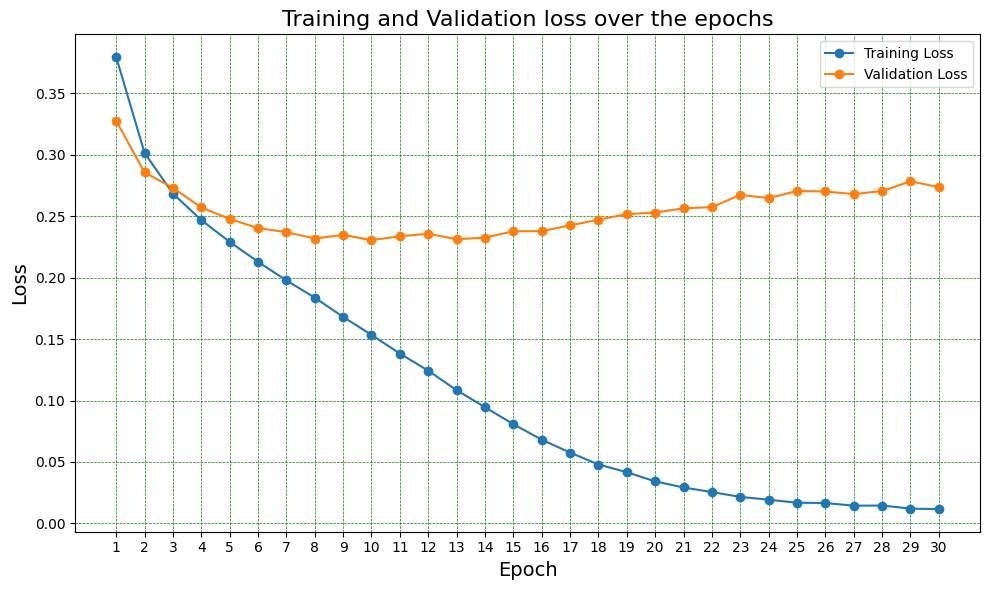

In [ ]:
plot_line_chart(losses, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', 'Training and Validation loss over the epochs')

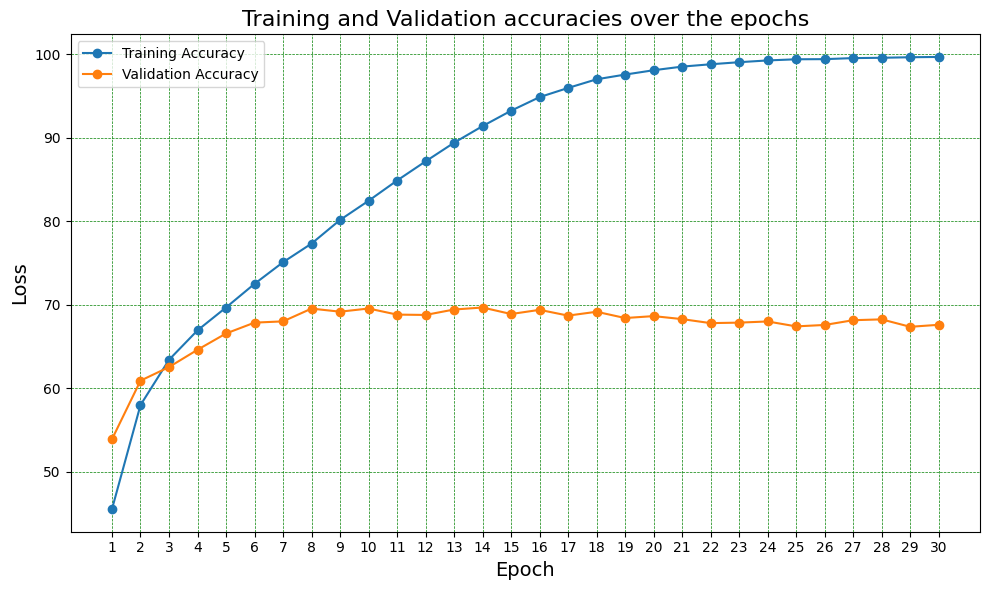

In [ ]:
plot_line_chart(accuracies, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', 'Training and Validation accuracies over the epochs')

In [ ]:
base_capsnet_cifar10_model = caps.BaseCapsuleNetwork(3, 32, 32, n_class=10)

best_trained_model = torch.load(CIFAR10_TRAIN_DIR+'Best_BaseCapsuleNetwork.pt')

base_capsnet_cifar10_model.load_state_dict(best_trained_model['model_state_dict'])
base_capsnet_cifar10_model.to(device)

print(base_capsnet_cifar10_model)

optimizer = Adam(base_capsnet_cifar10_model.parameters())

criterion = caps.CapsNetLoss(n_class)

BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)


In [7]:
n_class=10
n_epochs=50
batch_size=100
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# best_trained_ccm_model_path, losses_ccm, accuracies_ccm = train_capsnet(n_epochs,
#                                                                         base_capsnet_cifar10_model,
#                                                                         criterion,
#                                                                         optimizer,
#                                                                         train_loader,
#                                                                         test_loader,
#                                                                         CIFAR10_TRAIN_DIR,
#                                                                         calc_ccm=True)

12/16 08:29:46 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/500), Loss=0.0746, Top 1 Acc=91.00, Top 5 Acc=100.00
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/500), Loss=0.0746, Top 1 Acc=91.00, Top 5 Acc=100.00
12/16 08:30:02 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(100/500), Loss=0.0591, Top 1 Acc=93.27, Top 5 Acc=99.37
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(100/500), Loss=0.0591, Top 1 Acc=93.27, Top 5 Acc=99.37
12/16 08:30:18 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(200/500), Loss=0.0584, Top 1 Acc=93.36, Top 5 Acc=99.44
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(200/500), Loss=0.0584, Top 1 Acc=93.36, Top 5 Acc=99.44
12/16 08:30:34 PM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(300/500), Loss=0.0590, Top 1 Acc=93.25, Top 5 Acc=99.44
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(300/500), Loss=0.0590, Top 1 Acc=93.25, Top 5 Acc=99.44
12/16 08:30:50 PM | Ba

In [8]:
base_capsnet_cifar10_ccm_model = caps.BaseCapsuleNetwork(3, 32, 32, n_class=10)

best_trained_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_BaseCapsuleNetwork_CCM_Epoch30_of_30.pt')

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_model['model_state_dict'])
base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)

In [17]:
torch.cuda.empty_cache()

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.conv_layer.eval()

batch_ci_mean_list = []
batch = 0

with torch.no_grad():
    for images, _ in train_loader:
        batch += 1
        images = images.to(device)

        batch_feature_maps = base_capsnet_cifar10_ccm_model.conv_layer(images)
        batch_feature_maps = batch_feature_maps.detach().to(device)

        batch_ci = ccmp.ci_score(batch_feature_maps, device)
        batch_ci_mean = np.mean(batch_ci, axis=0)

        np.save(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_conv_layer_ci_scores_batch{}.npy'.format(batch), batch_ci_mean)

        batch_ci_mean_list.append(batch_ci_mean)
        torch.cuda.empty_cache()

    conv_layer_ci_mean = np.mean(batch_ci_mean_list, axis=0)

    np.save(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_conv_layer_ci_scores_final.npy', conv_layer_ci_mean)

    # torch.save(batch_feature_maps.detach(),
    #            CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ccm_conv_feature_maps_batch{}.pt'.format(n_batchs))

In [20]:
n_batchs

500

In [ ]:
ccm = torch.stack(ccm_list, dim=0)

In [ ]:
ccm.shape

torch.Size([500, 256, 256])

In [ ]:
ccm_mean = torch.mean(ccm, dim=0, keepdim=True)

In [ ]:
ccm_mean = ccm_mean.squeeze()

In [ ]:
for i in range(ccm_mean.shape[0]):
    for j in range(i, ccm_mean.shape[1]):
        if i !=j and ccm_mean[i,j] >= 0.95:
            print(i, j)

3 194
17 194
99 135
104 194
104 226
120 180
132 180
151 167
167 235
179 253
180 226
180 235
180 236
184 253
194 235
194 252
226 254
233 253
235 236
235 252


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        image = images[j-1]
        ax.imshow(image.T)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [ ]:
plot_images_separately(images[:6, :].cpu())

In [ ]:
recon_image = reconstructed_images[4]
recon_image = recon_image.cpu().detach().numpy()

plt.imshow(recon_image.T)